In [1]:
# Import libraries
import math
from scipy.stats import norm
import matplotlib.pyplot as plt

In [2]:
# Additional Inputs
RISK_FREE = float(input("Risk-free Rate: "))
DIVIDEND_YIELD = float(input("Dividend Yield: "))
SPOT = float(input("Current Spot Price: "))
VOLATILITY = float(input("Volatility: "))

Risk-free Rate: 0.05
Dividend Yield: 0.0051
Current Spot Price: 181.11
Volatility: 0.2979


In [3]:
# Black-Scholes Inputs
STRIKE = float(input("Strike Price: "))
EXPIRY = float(input("Time Until Expiration (yrs): "))

Strike Price: 180
Time Until Expiration (yrs): 0.013699


### Black-Scholes formula
$$C=S_0e^{-\delta(T-t)}N(d_1)-Ke^{-r(T-t)}N(d_2)$$
$$P=Ke^{-r(T-t)}N(-d_2)-S_0e^{-\delta(T-t)}N(-d_1)$$
$$\text{where }d_1=\frac{ln\frac{S_0}{K}+(r-\delta+\frac{\sigma^2}{2})(T-t)}{\sigma\sqrt{T-t}}$$
$$\text{and }d_2=d_1-\sigma\sqrt{T-t}$$
- $C=\text{European call price}$
- $P=\text{European put price}$
- $N(x)=\text{CDF of the normal distribution}$
- $S_0=\text{Current spot price}$
- $K=\text{Strike price}$
- $r=\text{Risk-free interest rate}$
- $\delta=\text{Dividend yield}$
- $T-t=\text{Time until expiration}$
- $\sigma=\text{Volatility of asset}$

### Measures of Risk

#### Delta
$$\text{Call }\Delta=\frac{\partial C}{\partial S}=e^{-\delta(T-t)}N(d_1)$$
$$\text{Put }\Delta=\frac{\partial P}{\partial S}=e^{-\delta(T-t)}N(d_1)-1$$

#### Vega
$$\mathcal{V}=\frac{\partial V}{\partial\sigma}=SN'(d_1)\sqrt{T-t}$$

#### Theta
$$\text{Call }\Theta=\frac{\partial C}{\partial t}=-\frac{SN'(d_1)\sigma}{2\sqrt{T-t}}-rKe^{-r(T-t)}N(d_2)$$
$$\text{Put }\Theta=\frac{\partial P}{\partial t}=-\frac{SN'(d_1)\sigma}{2\sqrt{T-t}}+rKe^{-r(T-t)}N(-d_2)$$

#### Rho
$$\text{Call }\mathrm{P}=\frac{\partial C}{\partial r}=K(T-t)e^{-r(T-t)}N(d_2)$$
$$\text{Put }\mathrm{P}=\frac{\partial P}{\partial r}=-K(T-t)e^{-r(T-t)}N(-d_2)$$

#### Gamma
$$\Gamma=\frac{\partial^2 V}{\partial S^2}=\frac{\partial \Delta}{\partial S}=e^{-\delta(T-t)}\frac{N'(d_1)}{S\sigma\sqrt{T-t}}$$

#### Vanna
$$\text{Vanna}=\frac{\partial \Delta}{\partial \sigma}=\frac{\partial \mathcal{V}}{\partial S}=\frac{\mathcal{V}}{S}\left[1 - \frac{d_1}{\sigma\sqrt{T-t}}\right]$$

In [4]:
class European:
    def __init__(self, strike: float, tte: float, call: bool):
        self.strike = strike
        self.tte = tte  # Time til expiration
        self.call = call
        
        self.spot = strike
        self.rfr = 0
        self.dy = 0
        self.vol = 0
    
    def set_inputs(self, spot: float, risk_free: float, dividend_yield: float, vol: float):
        self.spot = spot
        self.rfr = risk_free
        self.dy = dividend_yield
        self.vol = vol
    
    def get_d(self):
        d1 = (math.log(self.spot / self.strike) + (self.rfr - self.dy + 0.5 * pow(self.vol, 2)) * self.tte) / (self.vol * math.sqrt(self.tte))
        d2 = d1 - self.vol * math.sqrt(self.tte)
        return d1, d2
    
    def get_price(self):
        d1, d2 = self.get_d()
        if self.call:
            return self.spot * math.exp(-self.dy * self.tte) * norm.cdf(d1) - self.strike * math.exp(-self.rfr * self.tte) * norm.cdf(d2)
        else:
            return self.strike * math.exp(-self.rfr * self.tte) * norm.cdf(-d2) - self.spot * math.exp(-self.dy * self.tte) * norm.cdf(-d1)
    
    def get_delta(self):
        d1, _ = self.get_d()
        return math.exp(-self.dy * self.tte) * norm.cdf(d1) + (0 if self.call else -1)
    
    def get_vega(self):
        d1, _ = self.get_d()
        return self.spot * norm.pdf(d1) * math.sqrt(self.tte)
    
    def get_theta(self):
        d1, d2 = self.get_d()
        first_piece = -self.spot * norm.pdf(d1) * self.vol / (2 * math.sqrt(self.tte))
        second_piece = self.rfr * self.strike * math.exp(-self.rfr * self.tte) * (-norm.cdf(d2) if self.call else norm.cdf(-d2))
        return first_piece + second_piece
    
    def get_rho(self):
        _, d2 = self.get_d()
        return self.strike * self.tte * math.exp(-self.rfr * self.tte) * (norm.cdf(d2) if self.call else -norm.cdf(-d2))
    
    def get_gamma(self):
        d1, _ = self.get_d()
        return math.exp(-self.dy * self.tte) * norm.pdf(d1) / (self.spot * self.vol * math.sqrt(self.tte))
    
    def get_vanna(self):
        d1, _ = self.get_d()
        return self.get_vega() / self.spot * (1 - d1 / (self.vol * math.sqrt(self.tte)))


In [5]:
call_option = European(strike=STRIKE, tte=EXPIRY, call=True)
call_option.set_inputs(spot=SPOT, risk_free=RISK_FREE, dividend_yield=DIVIDEND_YIELD, vol=VOLATILITY)
print("Call price:", call_option.get_price())
print("Call delta:", call_option.get_delta())
print("Call vega:", call_option.get_vega())
print("Call theta:", call_option.get_theta())
print("Call rho:", call_option.get_rho())
print("Call gamma:", call_option.get_gamma())
print("Call vanna:", call_option.get_vanna())

put_option = European(strike=STRIKE, tte=EXPIRY, call=False)
put_option.set_inputs(spot=SPOT, risk_free=RISK_FREE, dividend_yield=DIVIDEND_YIELD, vol=VOLATILITY)
print("Put price:", put_option.get_price())
print("Put delta:", put_option.get_delta())
print("Put vega:", put_option.get_vega())
print("Put theta:", put_option.get_theta())
print("Put rho:", put_option.get_rho())
print("Put gamma:", put_option.get_gamma())
print("Put vanna:", put_option.get_vanna())

Call price: 3.167802893084584
Call delta: 0.583669188571264
Call vega: 8.26976569790592
Call theta: -95.04465526779315
Call rho: 1.4047026362082322
Call gamma: 0.06177583625960391
Call vanna: -0.23117783771030248
Put price: 1.9472068975719026
Put delta: -0.41633081142873596
Put vega: 8.26976569790592
Put theta: -86.05081770707083
Put rho: -1.059428978678469
Put gamma: 0.06177583625960391
Put vanna: -0.23117783771030248


In [6]:
call_prices = []
for days_left in range(1, 366):
    call_prices.append([])
    tte = days_left / 365.0
    opt = European(strike=STRIKE, tte=tte, call=True)
    for price in range(1, 251):
        opt.set_inputs(spot=price, risk_free=RISK_FREE, dividend_yield=DIVIDEND_YIELD, vol=VOLATILITY)
        call_prices[days_left - 1].append(opt.get_price())

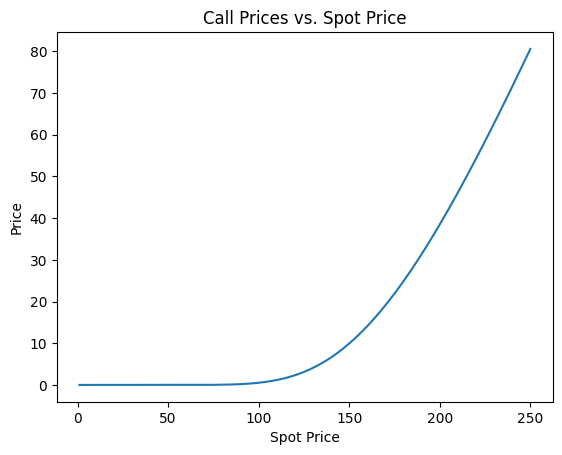

In [7]:
plt.plot(list(range(1, 251)), call_prices[364])
plt.title("Call Prices vs. Spot Price")
plt.xlabel("Spot Price")
plt.ylabel("Price")
plt.show()